<a href="https://colab.research.google.com/github/rameshcpoonia/ACO-with-TSP/blob/master/SEIRV_Model_COVID19_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Model

### Equations

\begin{equation}
\begin{split}
\dot{S} &= -\beta_1 I_1 S -\beta_2 I_2 S - \beta_3 I_3 S\\
\dot{E} &=\beta_1 I_1 S +\beta_2 I_2 S + \beta_3 I_3 S - a E +vinV (\beta_1 I_1 +\beta_2 I_2  + \beta_3 I_3 )\\
\dot{I_1} &= a E - \gamma_1 I_1 - p_1 I_1 \\
\dot{I_2} &= p_1 I_1 -\gamma_2 I_2 - p_2 I_2 \\
\dot{I_3} & = p_2 I_2 -\gamma_3 I_3 - \mu I_3 \\
\dot{R} & = \gamma_1 I_1 + \gamma_2 I_2 + \gamma_3 I_3 \\
\dot{D} & = \mu I_3\\
\dot{V} &= S vr-vinV(\beta_1 I_1 +\beta_2 I_2  + \beta_3 I_3 )\\
\end{split}
\end{equation}

### Variables
* $S$: Susceptible individuals
* $E$: Exposed individuals - infected but not yet infectious or symptomatic
* $I_i$: Infected individuals in severity class $i$. Severity increaes with $i$ and we assume individuals must pass through all previous classes
  * $I_1$: Mild infection (hospitalization not required)
  * $I_2$: Severe infection (hospitalization required)
  * $I_3$: Critical infection (ICU required)
* $R$: individuals who have recovered from disease and are now immune
* $D$: Dead individuals
* $V$: Vaccinated individuals
* $N=S+V+E+I_1+I_2+I_3+R+D$ Total population size (constant)

### Parameters
* $\beta_i$ rate at which infected individuals in class $I_i$ contact susceptibles and infect them so that they become exposed
* $vr$ rate at which individuals are vaccinated
* $vin$ vaccine inefficacy
* $a$ rate of progression from the exposed to infected class
* $\gamma_i$ rate at which infected individuals in class $I_i$ recover from disease and become immune
* $p_i$ rate at which infected individuals in class $I_i$ progress to class $I_{I+1}$
* $\mu$ death rate for individuals in the most severe stage of disease
* $br$ natural birth rate 



### Basic reproductive ratio

Idea: $R_0$ is the sum of 
1. the average number of secondary infections generated from an individual in stage $I_1$
2. the probability that an infected individual progresses to $I_2$ multiplied by the average number of secondary infections generated from an individual in stage $I_2$
3.  the probability that an infected individual progresses to $I_3$ multiplied by the average number of secondary infections generated from an individual in stage $I_3$

\begin{equation}
\begin{split}
R_0 & = N\frac{\beta_1}{p_1+\gamma_1} + \frac{p_1}{p_1 + \gamma_1} \left( \frac{N \beta_2}{p_2+\gamma_2} + \frac{p_2}{p_2 + \gamma_2} \frac{N \beta_3}{\mu+\gamma_3}\right)\\
&= N\frac{\beta_1}{p_1+\gamma_1} \left(1 + \frac{p_1}{p_2 + \gamma_2}\frac{\beta_2}{\beta_1} \left( 1 + \frac{p_2}{\mu + \gamma_3} \frac{\beta_3}{\beta_2} \right) \right)
\end{split}
\end{equation}


### Salient Features of Proposed Model
* Inclusion of parameters $vr$ rate at which individuals are vaccinated, $br$ natural birth rate,$nd$ natural death rate,$vin$ vaccine inefficacy.
* Severity of infections is also considered.
### Future research work
* Analysis of hospital resources done (mechanical ventilators, hospital beds).
* Doubling rate of pandemic also calculated (in progress).
* Social distancing norms also studied (in progress).

In [ ]:
#Reference paper for base model
#https://www.mdpi.com/2227-7390/9/6/636/pdf

In [ ]:
import numpy as np, matplotlib.pyplot as plt,pandas as pd
#to solve differential equations(ordinary differential integrator)
from scipy.integrate import odeint

In [ ]:

#Defining the differential equations


#include blank first entry in vector for beta, gamma, p so that indices align in equations and code. 
#In the future could include recovery or infection from the exposed class (asymptomatics)

def seir(y,t,b,a,g,p,u,N,vin,vr,nd): 
    dy=[0,0,0,0,0,0,0]
    S=N-sum(y);
    V=N-S-sum(y[0:6]);
    dy[0]=np.dot(b[1:3],y[1:3])*S-a*y[0]+vin*np.dot(b[1:3],y[1:3])*V # E
    dy[1]= a*y[0]-(g[1]+p[1])*y[1]#I1
    dy[2]= p[1]*y[1] -(g[2]+p[2])*y[2] #I2
    dy[3]= p[2]*y[2] -(g[3]+u)*y[3] #I3
    dy[4]= np.dot(g[1:3],y[1:3]) #R
    dy[5]=u*y[3] #D
    dy[6]=vr*S-vin*np.dot(b[1:3],y[1:3])*V#V
    
   
    return dy

In [ ]:
# Define parameters based on clinical observations

# https://github.com/midas-network/COVID-19/tree/master/parameter_estimates/2019_novel_coronavirus

IncubPeriod=5  #Incubation period, days
DurMildInf=10 #Duration of mild infections, days
FracMild=0.8  #Fraction of infections that are mild
FracSevere=0.15 #Fraction of infections that are severe
FracCritical=0.05 #Fraction of infections that are critical
CFR=0.02 #Case fatality rate (fraction of infections resulting in death)
TimeICUDeath=7 #Time from ICU admission to death, days
DurHosp=11 #Duration of hospitalization, days




In [ ]:

# Define parameters and run ODE

#Source of birth and death rate
#https://www.cdc.gov/nchs/fastats/deaths.htm
#https://data.worldbank.org/indicator/SP.DYN.CBRT.IN
br=1.1 #birth rate (per thousand)
nd=0.869# death rate(per thousand)
N=1000
N=1000+1.1*N-0.869*N

b=np.zeros(4) #beta
g=np.zeros(4) #gamma
p=np.zeros(3)



a=1/IncubPeriod

u=(1/TimeICUDeath)*(CFR/FracCritical)
g[3]=(1/TimeICUDeath)-u

p[2]=(1/DurHosp)*(FracCritical/(FracCritical+FracSevere))
g[2]=(1/DurHosp)-p[2]

g[1]=(1/DurMildInf)*FracMild
p[1]=(1/DurMildInf)-g[1]

#b=2e-4*np.ones(4) # all stages transmit equally
b=2.5e-4*np.array([0,1,0,0]) # hospitalized cases don't transmit

#Calculate basic reproductive ratio
R0=N*((b[1]/(p[1]+g[1]))+(p[1]/(p[1]+g[1]))*(b[2]/(p[2]+g[2])+ (p[2]/(p[2]+g[2]))*(b[3]/(u+g[3]))))
print("R0 = {0:4.1f}".format(R0))


R0 =  3.1


In [ ]:

print(b)
print(a)
print(g)
print(p)
print(u)

[0.      0.00025 0.      0.     ]
0.2
[0.         0.08       0.06818182 0.08571429]
[0.         0.02       0.02272727]
0.057142857142857134


(1, 1000)

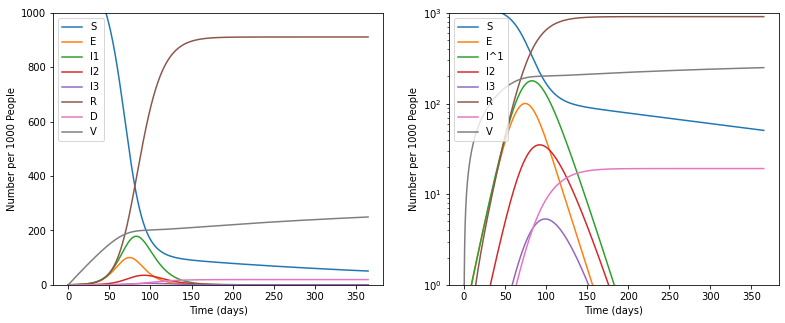

In [ ]:

tmax=365
tvec=np.arange(0,tmax,0.1)
ic=np.zeros(7)
ic[0]=1
#(1-0.95) vaccine inefficacy[efficacy:0.95]
vin=0.05 
#https://github.com/owid/covid-19-data/blob/master/public/data/vaccinations/country_data/United%20States.csv
vr=0.00267
soln=odeint(seir,ic,tvec,args=(b,a,g,p,u,N,vin,vr,nd))

soln=np.hstack((N-np.sum(soln,axis=1,keepdims=True),soln))

plt.figure(figsize=(13,5))
plt.subplot(1,2,1)
plt.plot(tvec,soln)
plt.xlabel("Time (days)")
plt.ylabel("Number per 1000 People")
plt.legend(("S","E","I1","I2","I3","R","D","V"))
plt.ylim([0,1000])

#Same plot but on log scale
plt.subplot(1,2,2)
plt.plot(tvec,soln)
plt.semilogy()
plt.xlabel("Time (days)")
plt.ylabel("Number per 1000 People")
plt.legend(("S","E","I^1","I2","I3","R","D","V"))
plt.ylim([1,1000])
#plt.tight_layout()

In [ ]:
print((soln))

[[1.23000000e+03 1.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.22967133e+03 9.80501073e-01 1.97043285e-02 ... 7.92557502e-05
  2.22232378e-11 3.28366131e-01]
 [1.22934215e+03 9.61978991e-01 3.88343673e-02 ... 3.14097281e-04
  3.41155830e-10 6.56644423e-01]
 ...
 [5.06525617e+01 3.75053682e-07 2.94327011e-06 ... 9.11712566e+02
  1.91939481e+01 2.49440917e+02]
 [5.06390393e+01 3.72190223e-07 2.92137743e-06 ... 9.11712566e+02
  1.91939481e+01 2.49454439e+02]
 [5.06255205e+01 3.69348631e-07 2.89964845e-06 ... 9.11712566e+02
  1.91939481e+01 2.49467958e+02]]


In [ ]:
# get observed growth rate r (and doubling time) for a particular variable between selected time points
#(all infected classes eventually grow at same rate during early infection)

#Don't have a simple analytic formula for r for this model due to the complexity of the stages

def growth_rate(tvec,soln,t1,t2,i):
  i1=np.where(tvec==t1)[0][0]
  i2=np.where(tvec==t2)[0][0]
  r=(np.log(soln[i2,1])-np.log(soln[i1,1]))/(t2-t1)
  DoublingTime=np.log(2)/r

  return r, DoublingTime

In [ ]:
(r,DoublingTime)=growth_rate(tvec,soln,10,20,1)
print("The pandemic growth rate is = {0:4.2f} per day and the doubling time {1:4.1f} days ".format(r,DoublingTime))

The pandemic growth rate is = 0.10 per day and the doubling time  7.2 days 


### Repeat but with a social distancing measure that reduces transmission rate

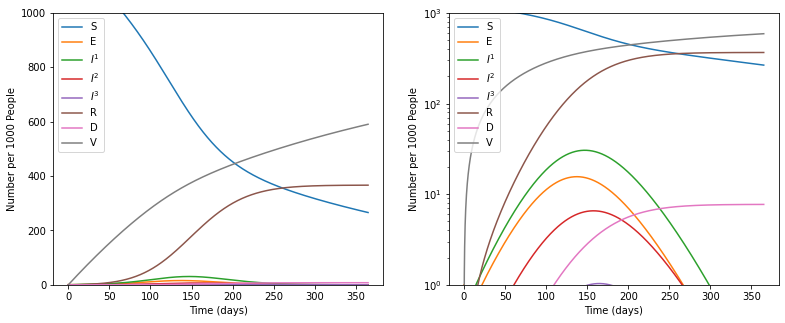

R0 under intervention =  1.8
The pandemic growth rate is = 0.04 per day and the doubling time 17.9 days 


In [ ]:
bSlow=0.6*b
R0Slow=N*((bSlow[1]/(p[1]+g[1]))+(p[1]/(p[1]+g[1]))*(bSlow[2]/(p[2]+g[2])+ (p[2]/(p[2]+g[2]))*(bSlow[3]/(u+g[3]))))

solnSlow=odeint(seir,ic,tvec,args=(bSlow,a,g,p,u,N,vin,vr,nd))
solnSlow=np.hstack((N-np.sum(solnSlow,axis=1,keepdims=True),solnSlow))

plt.figure(figsize=(13,5))
plt.subplot(1,2,1)
plt.plot(tvec,solnSlow)
plt.xlabel("Time (days)")
plt.ylabel("Number per 1000 People")
plt.legend(("S","E","$I^{1}$","$I^{2}$","$I^{3}$","R","D","V"))
plt.ylim([0,1000])

#Same plot but on log scale
plt.subplot(1,2,2)
plt.plot(tvec,solnSlow)
plt.semilogy()
plt.xlabel("Time (days)")
plt.ylabel("Number per 1000 People")
plt.legend(("S","E","$I^{1}$","$I^{2}$","$I^{3}$","R","D","V"))
plt.ylim([1,1000])

(rSlow,DoublingTimeSlow)=growth_rate(tvec,solnSlow,30,40,1)

plt.show()
print("R0 under intervention = {0:4.1f}".format(R0Slow))
print("The pandemic growth rate is = {0:4.2f} per day and the doubling time {1:4.1f} days ".format(rSlow,DoublingTimeSlow))


#### Compare pandemic growth with and without intervention

Text(0.5, 1.0, 'All infectious cases')

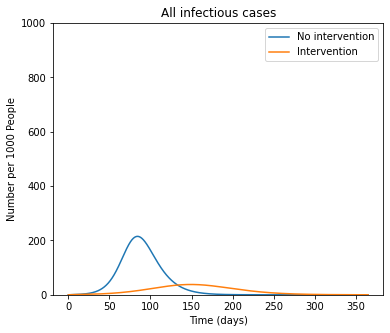

In [ ]:
### All infectious cases (not exposed)

plt.figure(figsize=(13,5))
plt.subplot(1,2,1)
plt.plot(tvec,np.sum(soln[:,2:5],axis=1,keepdims=True))
plt.plot(tvec,np.sum(solnSlow[:,2:5],axis=1,keepdims=True))
plt.xlabel("Time (days)")
plt.ylabel("Number per 1000 People")
plt.legend(("No intervention","Intervention"))
plt.ylim([0,1000])
plt.title('All infectious cases')

## COVID19 Cases vs Hospital Capacity

Depending on the severity ($I_i$) stage of COVID-19 infection, patients need different level of medical care. 

Individuals in $I_1$ have "mild" infection, meaning they have cough/fever/other flu-like symptoms and may also have mild pneumonia. Mild pneumonia does not require hospitalization, although in many outbreak locations like China and South Korea all symptomatic patients are being hospitalized. This is likely to reduce spread and to monitor these patients in case they rapidly progress to worse outcome. However, it is a huge burden on the health care system.

Individuals in $I_2$ have "severe" infection, which is categorized medically as having any of the following: "dyspnea, respiratory frequency 30/min, blood oxygen saturation 93%, partial pressure of arterial oxygen to fraction of inspired oxygen ratio $<$300, lung infiltrates $>$50% within 24 to 48 hours". These individuals require hospitalization but can be treated on regular wards. They may require supplemental oxygen. 

Individuals in $I_3$ have "critical" infection, which is categorized as having any of the following: "respiratory failure, septic shock, and/or multiple organ dysfunction or failure".
They require ICU-level care, generally because they need mechanical ventilation. 

We consider different scenarios for care requirements. One variation between scenarios is whether we include hospitalization for all individuals or only those with severe or critical infection. Another is the care of critical patients. If ICUs are full, hospitals have protocols developed for pandemic influenza to provide mechanical ventilation outside regular ICU facility and staffing requirements. Compared to "conventional" ventilation protocols, there are "contingency" and "crisis" protocols that can be adopted to increase patient loads. These protocols involve increasing patient:staff ratios, using non-ICU beds, and involving non-critical care specialists in patient care. 



In [ ]:
#Parameter sources: https://docs.google.com/spreadsheets/d/1zZKKnZ47lqfmUGYDQuWNnzKnh-IDMy15LBaRmrBcjqE

# All values are adjusted for increased occupancy due to flu season

AvailHospBeds=2.6*(1-0.66*1.1) #Available hospital beds per 1000 ppl in US based on total beds and occupancy
AvailICUBeds=0.26*(1-0.68*1.07) #Available ICU beds per 1000 ppl in US, based on total beds and occupancy. Only counts adult not neonatal/pediatric beds
ConvVentCap=0.062 #Estimated excess # of patients who could be ventilated in US (per 1000 ppl) using conventional protocols
ContVentCap=0.15 #Estimated excess # of patients who could be ventilated in US (per 1000 ppl) using contingency protocols
CrisisVentCap=0.42 #Estimated excess # of patients who could be ventilated in US (per 1000 ppl) using crisis protocols


### Assumptions: 1
* Only severe or critical cases go to the hospital
* All critical cases require ICU care and mechanical ventilation


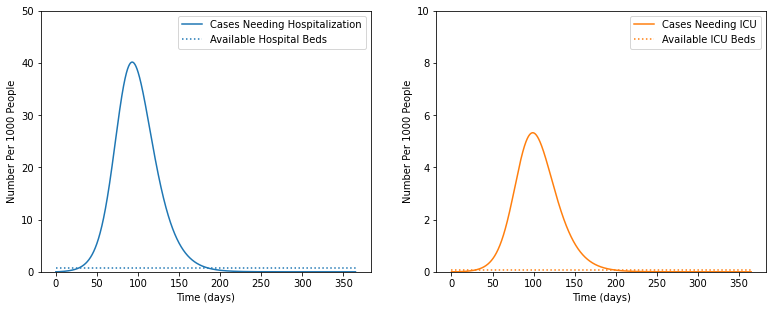

Hospital and ICU beds are filled by COVID19 patients after 27.7 and 29.3 days


In [ ]:
NumHosp=soln[:,3]+soln[:,4]
NumICU=soln[:,4]

plt.figure(figsize=(13,4.8))
plt.subplot(1,2,1)
plt.plot(tvec,NumHosp)
plt.plot(np.array((0, tmax)),AvailHospBeds*np.ones(2),color='C0',linestyle=":")
plt.xlabel("Time (days)")
plt.ylabel("Number Per 1000 People")
plt.legend(("Cases Needing Hospitalization","Available Hospital Beds"))
ipeakHosp=np.argmax(NumHosp) #find peak
peakHosp=10*np.ceil(NumHosp[ipeakHosp]/10)#find time at peak
plt.ylim([0,peakHosp])

plt.subplot(1,2,2)
plt.plot(tvec,NumICU,color='C1')
plt.plot(np.array((0, tmax)),AvailICUBeds*np.ones(2),color='C1',linestyle=":")
plt.xlabel("Time (days)")
plt.ylabel("Number Per 1000 People")
plt.legend(("Cases Needing ICU","Available ICU Beds"))
ipeakICU=np.argmax(NumICU) #find peak
peakICU=10*np.ceil(NumICU[ipeakICU]/10)#find time at peak
plt.ylim([0,peakICU])
plt.ylim([0,10])

#Find time when hospitalized cases = capacity
icross=np.argmin(np.abs(NumHosp[0:ipeakHosp]-AvailHospBeds)) #find intersection before peak
TimeFillBeds=tvec[icross]

#Find time when ICU cases = capacity
icross=np.argmin(np.abs(NumICU[0:ipeakICU]-AvailICUBeds)) #find intersection before peak
TimeFillICU=tvec[icross]

plt.show()
print("Hospital and ICU beds are filled by COVID19 patients after {0:4.1f} and {1:4.1f} days".format(TimeFillBeds,TimeFillICU))

Note that we have not taken into account the limited capacity in the model itself. If hospitals are at capacity, then the death rate will increase, since individuals with severe and critical infection will often die without medical care. The transmission rate will probably also increase, since any informal home-care for these patients will likely not include the level of isolation/precautions used in a hospital.

#### Allow for mechanical ventilation outside of ICUs using contingency or crisis capacity

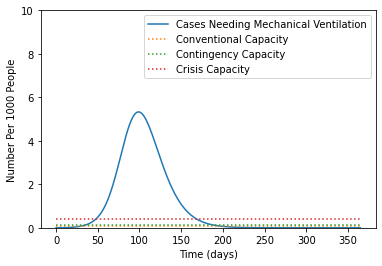

Capacity for mechanical ventilation is filled by COVID19 patients after 28.0 (conventional), 37.0 (contingency) and 48.3 (crisis) days


In [ ]:
plt.plot(tvec,NumICU)
plt.plot(np.array((0, tmax)),ConvVentCap*np.ones(2),linestyle=":")
plt.plot(np.array((0, tmax)),ContVentCap*np.ones(2),linestyle=":")
plt.plot(np.array((0, tmax)),CrisisVentCap*np.ones(2),linestyle=":")
plt.xlabel("Time (days)")
plt.ylabel("Number Per 1000 People")
plt.legend(("Cases Needing Mechanical Ventilation","Conventional Capacity","Contingency Capacity","Crisis Capacity"))
plt.ylim([0,peakICU])
plt.ylim([0,10])

#Find time when ICU cases = conventional capacity
icrossConv=np.argmin(np.abs(NumICU[0:ipeakICU]-ConvVentCap)) #find intersection before peak
TimeConvCap=tvec[icrossConv]
icrossCont=np.argmin(np.abs(NumICU[0:ipeakICU]-ContVentCap)) #find intersection before peak
TimeContCap=tvec[icrossCont]
icrossCrisis=np.argmin(np.abs(NumICU[0:ipeakICU]-CrisisVentCap)) #find intersection before peak
TimeCrisisCap=tvec[icrossCrisis]

plt.show()
print("Capacity for mechanical ventilation is filled by COVID19 patients after {0:4.1f} (conventional), {1:4.1f} (contingency) and {2:4.1f} (crisis) days".format(TimeConvCap,TimeContCap,TimeCrisisCap))

Compare to the case with intervention

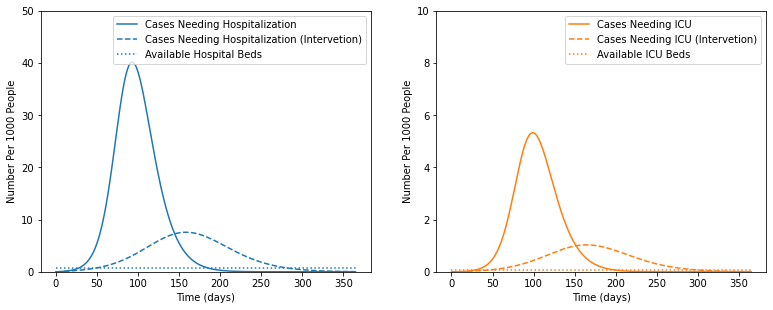

With intervention, hospital and ICU beds are filled by COVID19 patients after 48.7 and 46.3 days


In [ ]:
NumHospSlow=solnSlow[:,3]+solnSlow[:,4]
NumICUSlow=solnSlow[:,4]

plt.figure(figsize=(13,4.8))
plt.subplot(1,2,1)
plt.plot(tvec,NumHosp)
plt.plot(tvec,NumHospSlow,color='C0',linestyle="--")
plt.plot(np.array((0, tmax)),AvailHospBeds*np.ones(2),color='C0',linestyle=":")
plt.xlabel("Time (days)")
plt.ylabel("Number Per 1000 People")
plt.legend(("Cases Needing Hospitalization","Cases Needing Hospitalization (Intervetion)","Available Hospital Beds"))
plt.ylim([0,peakHosp])

plt.subplot(1,2,2)
plt.plot(tvec,NumICU,color='C1')
plt.plot(tvec,NumICUSlow,color='C1',linestyle="--")
plt.plot(np.array((0, tmax)),AvailICUBeds*np.ones(2),color='C1',linestyle=":")
plt.xlabel("Time (days)")
plt.ylabel("Number Per 1000 People")
plt.legend(("Cases Needing ICU","Cases Needing ICU (Intervetion)","Available ICU Beds"))
plt.ylim([0,peakICU])

#Find time when hospitalized cases = capacity
ipeakHospSlow=np.argmax(NumHospSlow) #find peak
icross=np.argmin(np.abs(NumHospSlow[0:ipeakHospSlow]-AvailHospBeds)) #find intersection before peak
TimeFillBedsSlow=tvec[icross]

#Find time when ICU cases = capacity
ipeakICUSlow=np.argmax(NumICUSlow) #find peak
icross=np.argmin(np.abs(NumICUSlow[0:ipeakICU]-AvailICUBeds)) #find intersection before peak
TimeFillICUSlow=tvec[icross]

plt.show()
print("With intervention, hospital and ICU beds are filled by COVID19 patients after {0:4.1f} and {1:4.1f} days".format(TimeFillBedsSlow,TimeFillICUSlow))

And for expanded mechanical ventilation capacity

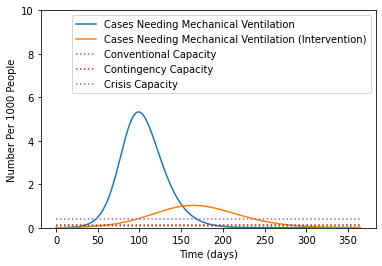

Capacity for mechanical ventilation is filled by COVID19 patients after 43.2 (conventional), 65.6 (contingency) and 98.5 (crisis) days


In [ ]:
plt.plot(tvec,NumICU)
plt.plot(tvec,NumICUSlow)
plt.plot(np.array((0, tmax)),ConvVentCap*np.ones(2),linestyle=":")
plt.plot(np.array((0, tmax)),ContVentCap*np.ones(2),linestyle=":")
plt.plot(np.array((0, tmax)),CrisisVentCap*np.ones(2),linestyle=":")
plt.xlabel("Time (days)")
plt.ylabel("Number Per 1000 People")
plt.legend(("Cases Needing Mechanical Ventilation","Cases Needing Mechanical Ventilation (Intervention)","Conventional Capacity","Contingency Capacity","Crisis Capacity"))
plt.ylim([0,peakICU])

#Find time when ICU cases = conventional capacity (with intervention)
icrossConvSlow=np.argmin(np.abs(NumICUSlow[0:ipeakICUSlow]-ConvVentCap)) #find intersection before peak
TimeConvCapSlow=tvec[icrossConvSlow]
icrossContSlow=np.argmin(np.abs(NumICUSlow[0:ipeakICUSlow]-ContVentCap)) #find intersection before peak
TimeContCapSlow=tvec[icrossContSlow]
icrossCrisisSlow=np.argmin(np.abs(NumICUSlow[0:ipeakICUSlow]-CrisisVentCap)) #find intersection before peak
TimeCrisisCapSlow=tvec[icrossCrisisSlow]

plt.show()
print("Capacity for mechanical ventilation is filled by COVID19 patients after {0:4.1f} (conventional), {1:4.1f} (contingency) and {2:4.1f} (crisis) days".format(TimeConvCapSlow,TimeContCapSlow,TimeCrisisCapSlow))

Interpretation:Interpretation: While interventions that reduce infectiousness do "flatten the curve", cases are still a little WAY over hospital capacity. There is no way to get anywhere close to staying under hospital bed capacity or mechanical ventilation capacity without reducing $R_0<1$.

**Studying effectiveness of various vaccines in USA**

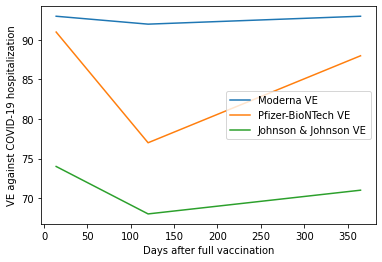

Hence after full survillence period: 93 ,88,and 71 is full vaccine effectiveness of moderna , pfizer ,johnson and johnson respectively 


In [ ]:
#https://www.cdc.gov/mmwr/volumes/70/wr/mm7038e1.htm#T1_down
x = [14, 120,365]
y = [93, 92, 93]
y2 =[91,77,88]
y3=[74,68,71]

fig, ax = plt.subplots()

ax.plot(x, y,label="Moderna VE")
ax.plot(x, y2,label="Pfizer-BioNTech VE")
ax.plot(x,y3,label="Johnson & Johnson VE")
ax.legend(loc = 'right')
plt.xlabel("Days after full vaccination")
plt.ylabel("VE against COVID-19 hospitalization")
plt.show()
print("Hence after full survillence period: 93 ,88,and 71 is full vaccine effectiveness of moderna , pfizer ,johnson and johnson respectively ")

### Assumptions: 2
* All cases go to the hospital
* All critical cases require ICU care and mechanical ventilation

Note: No point running this scenario because it would be even more extreme than Assumption 1 (mild cases stayed home) and Assumption 1 already lead to rapid overlow of hospital resources


### Assumptions: 3
* Only severe or critical cases go to the hospital
* All critical cases require ICU care and mechanical ventilation
* When hospital capacity is exceed, individual dies

Note: Could be used to simulate expected increases in death if capacity exceeded


**DOUBTS :**

1.   Factors for considerig PEAK for third wave
2.   Integrating vaccine inefficacy and vaccination in Reproduction rate



In [ ]:
df=pd.read_csv("https://raw.githubusercontent.com/nytimes/covid-19-data/master/us.csv")

In [ ]:
df.head()

,date,cases,deaths
0,2020-01-21,1,0
1,2020-01-22,1,0
2,2020-01-23,1,0
3,2020-01-24,2,0
4,2020-01-25,3,0


In [ ]:
df.describe()

,cases,deaths
count,8.040000e+02,804.000000
mean,2.720553e+07,442260.699005
std,2.354315e+07,300846.874882
min,1.000000e+00,0.000000
25%,5.044318e+06,162351.250000
50%,2.847142e+07,509195.000000
75%,4.150824e+07,664880.250000
max,8.005690e+07,980027.000000


[]

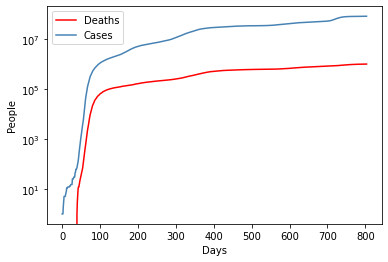

In [ ]:
#plotting according to time series
plt.plot(df['deaths'], label='Deaths', color='red')
plt.plot(df['cases'], label='Cases', color='steelblue')

plt.xlabel("Days")
plt.ylabel("People")
plt.legend()
plt.semilogy()